In [25]:
import PyPDF2
import re
from collections import defaultdict

def extract_toc_page_ranges_from_text(toc_text, total_pdf_pages):
    """
    Parses ToC text to extract section names and their page ranges.

    Args:
        toc_text (str): The raw text extracted from the ToC pages.
        total_pdf_pages (int): The total number of pages in the PDF document.

    Returns:
        list: A list of tuples, where each tuple is (section_name, start_page, end_page).
              Page numbers are assumed to be 1-indexed as they appear in the ToC.
    """
    sections_with_start_pages = []
    lines = toc_text.split('\n')

    # Regex to capture section name and page number from lines like:
    # "Section Name .................... PageNumber"
    # - ^(.*?) : Captures the section name (non-greedy) from the start of the line.
    # - \s*\.{2,}\s* : Matches the dots (at least two) with optional surrounding spaces.
    # - (\d+) : Captures the page number.
    # - \s*$ : Matches optional trailing spaces until the end of the line.
    pattern = re.compile(r"^(.*?)\s*\.{2,}\s*(\d+)\s*$")

    for line in lines:
        line = line.strip()  # Remove leading/trailing whitespace from the line
        match = pattern.match(line)
        if match:
            section_name = match.group(1).strip()
            # Further clean section name: remove any trailing dots that might be part of the name
            # but were intended as leaders if the regex was slightly too greedy or format is odd.
            section_name = re.sub(r'\s*\.+\s*$', '', section_name).strip()
            
            # Skip entries that are likely just dots or very short, potentially misidentified lines
            if not section_name or len(section_name) < 2: # Basic filter
                continue

            try:
                page_number = int(match.group(2))
                sections_with_start_pages.append({"name": section_name, "start_page": page_number})
            except ValueError:
                # If page number isn't a valid integer, skip this line
                print(f"Warning: Could not parse page number for line: '{line}'")
                continue
    
    # Sort sections by start page to handle ToCs that might not be strictly in order
    # or if parsing extracts them non-sequentially (though line-by-line usually is sequential).
    sections_with_start_pages.sort(key=lambda x: x["start_page"])

    sections = defaultdict(list)
    processed_sections = []
    num_extracted_sections = len(sections_with_start_pages)

    for i in range(num_extracted_sections):
        current_section = sections_with_start_pages[i]
        section_name = current_section["name"]
        start_page = current_section["start_page"]

        end_page = -1  # Default/placeholder

        if i + 1 < num_extracted_sections:
            next_section_start_page = sections_with_start_pages[i+1]["start_page"]
            # Ensure end page is not before start page (e.g. if next section starts on same page)
            if next_section_start_page > start_page:
                end_page = next_section_start_page - 1
            else: # Next section starts on same page or earlier (unusual for ToC)
                end_page = start_page 
        else:
            # For the last section, its end page is the last page of the document.
            # We assume ToC page numbers are 1-indexed.
            end_page = total_pdf_pages

        # Final sanity check for end_page
        if end_page < start_page:
            end_page = start_page # Should not happen if logic above is correct

        pattern_sec = re.compile(r"\d*\.\d+|\d")
        if pattern_sec.match(section_name):
            
            section_number = section_name.split()[0].split('.')[0]
            if section_number in sections:
                sections[section_number].append((section_name, start_page, end_page))
            else:
                sections[section_number] = []

        processed_sections.append((section_name, start_page, end_page))

        print(sections)

    return processed_sections

def get_toc_sections_from_pdf(pdf_path, toc_actual_start_page, toc_actual_end_page):
    """
    Extracts ToC sections and their page ranges from a PDF file.

    Args:
        pdf_path (str): Path to the PDF file.
        toc_actual_start_page (int): The actual starting page number of the ToC in the PDF (1-indexed).
        toc_actual_end_page (int): The actual ending page number of the ToC in the PDF (1-indexed).

    Returns:
        list: A list of tuples (section_name, start_page, end_page), or empty list on error.
    """
    try:
        with open(pdf_path, 'rb') as file:
            reader = PyPDF2.PdfReader(file)
            total_pdf_pages = len(reader.pages)
            
            if not (0 < toc_actual_start_page <= toc_actual_end_page <= total_pdf_pages):
                print("Error: Invalid ToC page range provided.")
                return []

            toc_text = ""
            # PyPDF2 uses 0-indexed pages, so adjust
            for page_num_0_indexed in range(toc_actual_start_page - 1, toc_actual_end_page):
                if page_num_0_indexed < total_pdf_pages:
                    page = reader.pages[page_num_0_indexed]
                    toc_text += page.extract_text() + "\n" # Add newline for better line splitting
                else:
                    print(f"Warning: Page number {page_num_0_indexed + 1} is out of bounds.")
                    break
        
        if not toc_text.strip():
            print("Warning: No text extracted from ToC pages.")
            return []
            
        return extract_toc_page_ranges_from_text(toc_text, total_pdf_pages)

    except FileNotFoundError:
        print(f"Error: The file '{pdf_path}' was not found.")
        return []
    except PyPDF2.errors.PdfReadError:
        print(f"Error: Could not read the PDF file '{pdf_path}'. It might be corrupted or not a valid PDF.")
        return []
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
        return []

if __name__ == "__main__":
    pdf_file = "esma_report.pdf"  # Replace with your PDF file name/path

    # IMPORTANT: Manually identify these page numbers from your PDF viewer.
    # These are the ACTUAL page numbers as you see them in the PDF viewer (1-indexed).
    # For your example, if the ToC is on pages "iii" and "iv", and these correspond to
    # the 3rd and 4th pages of the document overall, you'd use 3 and 4.
    # If your ToC starts on page 2 and ends on page 3 (as per previous example):
#     toc_start_page_in_pdf = 1  # Example: if ToC starts on page 'iii' which is 3rd page
#     toc_end_page_in_pdf   = 4  # Example: if ToC ends on page 'iv' which is 4th page

#     # Example using the provided text directly (for testing the parsing logic)
#     print("--- Testing with provided text sample ---")
#     sample_toc_text = """
# Annex: Guidelines for reporting under EMIR  ................................ ................................ .........  6
# 1 Legislative references, abbreviations and definitions  ................................ ......................  6
# 1 Scope  ................................ ................................ ................................ .............................  9
# 2 Purpose  ................................ ................................ ................................ ......................... 10
# 3 General Principles  ................................ ................................ ................................ ......... 11
# 3.1 Transition to reporting under the RTS and ITS on reporting  ................................ ...11
# 3.2 Determining the number of reportable derivatives 
#     """
#     # Assume the document from which this sample comes has 50 pages for this test
#     sample_total_pages = 50 
#     parsed_sample_sections = extract_toc_page_ranges_from_text(sample_toc_text, sample_total_pages)
#     if parsed_sample_sections:
#         print("Parsed Sections from Sample Text:")
#         for name, start, end in parsed_sample_sections:
#             print(f"- \"{name}\": pages {start}-{end}")
#     else:
#         print("Could not parse sections from the sample text.")
#     print("-" * 40)

#     print(f"\n--- Attempting to extract ToC from PDF: {pdf_file} ---")
    # Ensure you have 'esma_report.pdf' and have set toc_start_page_in_pdf and toc_end_page_in_pdf correctly
    # For this to work, you need to set `toc_start_page_in_pdf` and `toc_end_page_in_pdf`
    # to the correct page numbers where the Table of Contents is located in *your* PDF.
    # For example, if your ToC is on pages 3 and 4 of the PDF:
    # toc_start_page_in_pdf = 3
    # toc_end_page_in_pdf = 4
    
    # Update these based on your actual PDF's ToC location:
    # For demonstration, I'll use placeholder values. You MUST change these.
    actual_toc_start_page = 1 # Placeholder - CHANGE THIS
    actual_toc_end_page = 4   # Placeholder - CHANGE THIS

    section_ranges = get_toc_sections_from_pdf(pdf_file, actual_toc_start_page, actual_toc_end_page)

    # if section_ranges:
    #     print("\nExtracted Section Page Ranges from PDF:")
    #     for name, start, end in section_ranges:
    #         # The page numbers here are 1-indexed, as they appear in the ToC
    #         print(f"- Section: \"{name}\", Pages: {start}-{end}")
    # else:
    #     print(f"Could not extract section page ranges from '{pdf_file}'. "
    #           "Please check ToC page numbers and PDF content.")



defaultdict(<class 'list'>, {})
defaultdict(<class 'list'>, {'1': []})
defaultdict(<class 'list'>, {'1': [('1 Scope  ................................ ................................', 9, 9)]})
defaultdict(<class 'list'>, {'1': [('1 Scope  ................................ ................................', 9, 9)], '2': []})
defaultdict(<class 'list'>, {'1': [('1 Scope  ................................ ................................', 9, 9)], '2': [], '3': []})
defaultdict(<class 'list'>, {'1': [('1 Scope  ................................ ................................', 9, 9)], '2': [], '3': [('3.1 Transition to reporting under the RTS and ITS on reporting', 11, 11)]})
defaultdict(<class 'list'>, {'1': [('1 Scope  ................................ ................................', 9, 9)], '2': [], '3': [('3.1 Transition to reporting under the RTS and ITS on reporting', 11, 11), ('3.2 Determining the number of reportable derivatives', 12, 12)]})
defaultdict(<class 'list'>, {'1': [('

In [26]:
a = "3.2.1"

In [33]:
".".join(a.split(".")[:2])

'3.2'

Attempting to extract Hierarchical ToC from PDF: esma_report.pdf

Successfully extracted Hierarchical ToC Data.

--- Processing sections, extracting text, and sending to Vertex AI for document: esma_report.pdf ---
--- Sending to Vertex AI (Placeholder) ---
Document: esma_report.pdf
Section ID: Annex
Title: Guidelines for reporting under EMIR  ................................
Start Page: 6
End Page: 6
Extracted Text:
5
----------------------------------------
--- Sending to Vertex AI (Placeholder) ---
Document: esma_report.pdf
Section ID: 1
Title: Legislative references, abbreviations and definitions
Start Page: 6
End Page: 8
Extracted Text (first 500 chars):
5 
  
 
 
 
6 
Annex: Guidelines for reporting under EMIR  
1 Legislative references, abbreviations and definitions  
Legislative references  
  
EMIR  Regulation (EU) 648/2012 of the European Parliament and 
Council on OTC derivatives, central counterparties and trade 
repositories - European Market Infrastructures Regulation1 
SF

In [13]:
import os
import requests

from google.oauth2 import service_account
from google.auth.transport.requests import Request
from langchain_core.callbacks import CallbackManagerForLLMRun
from typing import Any, Optional, ClassVar
from langchain_core.language_models.llms import LLM


# Set proxy environment variables for DB network
os.environ['HTTP_PROXY'] = 'http://sp-surf-proxy.intranet.db.com:8080'
os.environ['HTTPS_PROXY'] = 'http://sp-surf-proxy.intranet.db.com:8080'


class VertexAILangchainLLM(LLM):
    """
    LangChain LLM class for interacting with Vertex AI using direct HTTP requests.
    """
    project_id: ClassVar[str] = "db-dev-ny3a-flare-dev-1"
    location:ClassVar[str] = "europe-west3"
    model_name:ClassVar[str] = "gemini-1.5-pro-002"
    credentials_path:ClassVar[str] = 'keyfile_new.json'
    if os.getenv('HTTP_PROXY'):
        proxies = {
            'http': os.getenv('HTTP_PROXY'),
            'https': os.getenv('HTTPS_PROXY')
        }   
    else:
        proxies = {}

    temperature: int = 0
    credentials: str = ""

    def __init__(self, model_params: dict):
        """
        Initialize the VertexAILangchainLLM.

        Args:
            model_params: A dictionary containing model parameters.
                - location: The location of the Vertex AI endpoint.
                - model_name: The name of the model to use.
                - temperature: The temperature for text generation.
                - credentials_path: Optional path to service account key file.
        """
        super().__init__()
        if 'temperature' not in model_params:
            model_params['temperature'] = 0.5
        else:
            self.temperature = model_params['temperature']

        # if 'location' not in model_params:
        #     raise ValueError("location must be provided in model_params")

        # if 'model_name' not in model_params:
        #     raise ValueError("model_name must be provided in model_params")
        

        self.authenticate()

    @property
    def _llm_type(self) -> str:
        return "custom"

    def authenticate(self):
        """
        Authenticate with Vertex AI using service account credentials.

        Args:
            project_id: The GCP project ID
            credentials_path: Optional path to service account key file
        """

        if self.credentials_path:
            os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = self.credentials_path

        if not os.getenv('GOOGLE_APPLICATION_CREDENTIALS'):
            raise ValueError("GOOGLE_APPLICATION_CREDENTIALS not set")

        self.credentials = service_account.Credentials.from_service_account_file(
            os.getenv('GOOGLE_APPLICATION_CREDENTIALS'),
            scopes=['https://www.googleapis.com/auth/cloud-platform']
        )

    def _call(self,
              prompt: str,
              run_manager: Optional[CallbackManagerForLLMRun] = None,
              **kwargs: Any
              ) -> str:
        try:
            if not self.credentials.valid:
                self.credentials.refresh(Request())

            url = f"https://{self.location}-aiplatform.googleapis.com/v1/projects/{self.project_id}/locations/{self.location}/publishers/google/models/{self.model_name}:generateContent"

            headers = {
                "Authorization": f"Bearer {self.credentials.token}",
                "Content-Type": "application/json",
                "x-goog-request-params": "vpc-sc-bypass=true",
                "x-goog-user-project": self.project_id,
                "x-goog-vpc-service-controls": "true"
            }

            data = {
                "contents": [{
                    "role": "user",
                    "parts": [{
                        "text": prompt
                    }]
                }],
                "generationConfig": {
                    "temperature": self.temperature
                }
            }

            response = requests.post(url, headers=headers, json=data) #proxies=self.proxies)
            if response.status_code == 200:
                response_json = response.json()
                if 'candidates' in response_json and len(response_json['candidates']) > 0:
                    text = response_json['candidates'][0]['content']['parts'][0]['text']
                    return text
                raise Exception("No text found in response")
            else:
                error_message = response.text
                print(f"Full error: {error_message}")
                if "VPC_SERVICE_CONTROLS" in error_message:
                    raise Exception("Please ensure you're connected to DB VPN")
                elif "PERMISSION_DENIED" in error_message:
                    raise Exception("Check service account permissions")
                else:
                    raise Exception(f"API Error: {error_message}")

        except requests.exceptions.RequestException as e:
            print(f"Error making API request: {str(e)}")
            raise
        except Exception as e:
            print(f"Error generating response: {str(e)}")
            raise

In [12]:
import PyPDF2
import re
import json 
from langchain.prompts.chat import ChatPromptTemplate
from langchain.prompts.chat import HumanMessagePromptTemplate


MAX_SECTIONS_TO_PROCESS_AND_SEND = 999999999

def _parse_toc_line_for_hierarchy(full_name_from_toc):
    stripped_name = full_name_from_toc.strip()
    m_numeric = re.match(r"^(\d+(?:\.\d+)*)\s+(.*)", stripped_name)
    if m_numeric:
        id_str = m_numeric.group(1)
        title = m_numeric.group(2).strip()
        level = len(id_str.split('.'))
        return level, id_str, title
    
    parts = stripped_name.split(None, 1)
    if not parts: return 1, "UnknownSection", "Unknown Title"
    id_str = parts[0].rstrip(':')
    title = parts[1].strip() if len(parts) > 1 else id_str
    if len(id_str) > 25 and id_str == title:
        short_id_candidate = "_".join(title.split()[:2]).lower()
        id_str = "".join(filter(str.isalnum, short_id_candidate))[:15]
        if not id_str : id_str = "section"
    return 1, id_str, title

def build_hierarchical_toc(flat_toc_entries_with_pages):
    structured_toc_root = []
    parent_stack = [(0, structured_toc_root)]
    for full_name, start_p, end_p in flat_toc_entries_with_pages:
        level, id_val, title_val = _parse_toc_line_for_hierarchy(full_name)
        entry = {
            'id': id_val,
            'title': title_val,
            'start_page': start_p,
            'end_page': end_p,
            'subsections': []
        }
        while parent_stack[-1][0] >= level:
            parent_stack.pop()
        _parent_level, parent_children_list = parent_stack[-1]
        parent_children_list.append(entry)
        parent_stack.append((level, entry['subsections']))
    return structured_toc_root

def extract_flat_toc_with_pages(toc_text, total_pdf_pages):
    sections_with_start_pages = []
    lines = toc_text.split('\n')
    pattern = re.compile(r"^(.*?)\s*\.{2,}\s*(\d+)\s*$")
    for line in lines:
        line = line.strip()
        match = pattern.match(line)
        if match:
            section_name = match.group(1).strip()
            section_name = re.sub(r'\s*\.+\s*$', '', section_name).strip()
            if not section_name or len(section_name) < 2: continue
            try:
                page_number = int(match.group(2))
                sections_with_start_pages.append({"full_name": section_name, "start_page": page_number})
            except ValueError:
                print(f"Warning: Could not parse page number for line: '{line}'")
                continue
    sections_with_start_pages.sort(key=lambda x: x["start_page"])
    processed_sections_flat = []
    num_extracted = len(sections_with_start_pages)
    for i in range(num_extracted):
        current_section = sections_with_start_pages[i]
        full_name = current_section["full_name"]
        start_page = current_section["start_page"]
        end_page = total_pdf_pages
        if i + 1 < num_extracted:
            next_section_start_page = sections_with_start_pages[i+1]["start_page"]
            end_page = next_section_start_page - 1 if next_section_start_page > start_page else start_page
        if end_page < start_page: end_page = start_page
        processed_sections_flat.append((full_name, start_page, end_page))
    return processed_sections_flat

def get_hierarchical_toc_from_pdf(pdf_path, toc_actual_start_page, toc_actual_end_page):
    try:
        with open(pdf_path, 'rb') as file:
            reader = PyPDF2.PdfReader(file)
            total_pdf_pages = len(reader.pages)
            if not (0 < toc_actual_start_page <= toc_actual_end_page <= total_pdf_pages):
                print("Error: Invalid ToC page range provided.")
                return None, 0 

            toc_text = ""
            for page_num_0_indexed in range(toc_actual_start_page - 1, toc_actual_end_page):
                if page_num_0_indexed < total_pdf_pages:
                    page = reader.pages[page_num_0_indexed]
                    toc_text += page.extract_text() + "\n"
                else:
                    print(f"Warning: Page number {page_num_0_indexed + 1} is out of bounds for ToC.")
                    break
        
        if not toc_text.strip():
            print("Warning: No text extracted from ToC pages.")
            return None, total_pdf_pages
            
        flat_toc_entries = extract_flat_toc_with_pages(toc_text, total_pdf_pages)
        if not flat_toc_entries:
            print("Warning: Could not parse any flat ToC entries.")
            return None, total_pdf_pages
            
        hierarchical_toc = build_hierarchical_toc(flat_toc_entries)
        return hierarchical_toc, total_pdf_pages

    except FileNotFoundError:
        print(f"Error: The file '{pdf_path}' was not found.")
        return None, 0
    except PyPDF2.errors.PdfReadError as e:
        print(f"Error: Could not read the PDF file '{pdf_path}'. It might be corrupted or not a valid PDF: {e}")
        return None, 0
    except Exception as e:
        print(f"An unexpected error occurred during ToC extraction: {e}")
        return None, 0

def extract_text_from_page_range(pdf_reader, start_page_1_indexed, end_page_1_indexed):
    text_content = ""
    try:
        num_doc_pages = len(pdf_reader.pages)
        start_idx = max(0, start_page_1_indexed - 1)
        end_idx = min(num_doc_pages -1 , end_page_1_indexed - 1)

        if start_idx > end_idx : 
            print(f"Warning: Invalid page range for text extraction. Start: {start_page_1_indexed}, End: {end_page_1_indexed}")
            return ""

        for page_num in range(start_idx, end_idx + 1):
            if page_num < num_doc_pages:
                page = pdf_reader.pages[page_num]
                extracted = page.extract_text()
                if extracted:
                    text_content += extracted + "\n" 
            else:
                print(f"Warning: Page number {page_num + 1} is out of bounds during text extraction.")
                break 
        return text_content.strip()
    except Exception as e:
        print(f"Error extracting text from pages {start_page_1_indexed}-{end_page_1_indexed}: {e}")
        return ""


def send_data_to_vertex_ai(section_payload, document_name):
    print(f"Document: {document_name}")
    print(f"Section ID: {section_payload.get('id')}")
    print(f"Title: {section_payload.get('title')}")
    print(f"Start Page: {section_payload.get('start_page')}")
    print(f"End Page: {section_payload.get('end_page')}")
    # print(f"Extracted Text:\n{section_payload.get('text_content')[:500]}...") # Print start of text

    if len(section_payload.get('text_content', '')) > 500:
        print(f"Extracted Text (first 500 chars):\n{section_payload.get('text_content')[:500]}...")
    else:
        print(f"Extracted Text:\n{section_payload.get('text_content')}")
    print("----------------------------------------")

    
    if len(section_payload.get('text_content', '')) > 10:
        print(f"--- Sending to Vertex AI (Placeholder) ---")
        messages = []

        template = get_prompt()
        human_template = HumanMessagePromptTemplate.from_template(template)
        messages.append(human_template)
        chat_prompt = ChatPromptTemplate.from_messages(messages)
        section_name = section_payload.get('title')
        request = chat_prompt.format_prompt(section_name=section_name,
                                            text_contents=section_payload.get('text_content'),
                                            ).to_messages()
        
        request_dicts = [{"role": msg.type, "content": msg.content} for msg in request]

        print(f"request_dicts: {request_dicts}")

        with open(f"summary/{section_name}.txt",'w') as f:
            llm = VertexAILangchainLLM({})
            try:
                response = llm._call(prompt=str(request_dicts))
                f.write(response)
                return response

            except Exception as e:
                print("Some error occered"+e)
    return True
 

def get_prompt():
    prompt ="""
        **Objective:** Analyze the provided document to produce a clear summary that includes all key points and their locations (page numbers). The output should be structured to facilitate the easy creation of a knowledge graph or conceptual map with source attribution.

        **Document Text:**
        Section Name
        --------------------
        {section_name}

        Text
        -------------------
        {text_contents}

        **Instructions:**

        Please analyze the document and provide the following information in a structured format:

        1.  **Overall Document Summary:**
            *   A concise summary (3-5 sentences) that clearly captures the main purpose, core arguments, and overall conclusions of the document.

        2.  **Key Entities/Concepts (Nodes):**
            *   Identify and list the most important entities, concepts, organizations, individuals, processes, or items discussed. These will serve as the primary nodes in a graph.
            *   For each entity/concept, provide a brief (1-sentence) description of its role or significance within the document and the page number(s) where it is prominently mentioned or defined.
            *   **Format:**
                *   **Entity/Concept:** [Name of Entity/Concept 1]
                    *   **Description:** [Brief description of its role/significance]
                    *   **Page Number(s):** [e.g., 5, 12-14]
                *   **Entity/Concept:** [Name of Entity/Concept 2]
                    *   **Description:** [Brief description of its role/significance]
                    *   **Page Number(s):** [e.g., 3, 8]
                *   ... (List all significant entities/concepts)

        3.  **Key Relationships/Interactions (Edges):**
            *   Describe the significant relationships, interactions, dependencies, influences, or actions between the identified key entities/concepts. These will form the edges in a graph.
            *   Clearly state the source entity/concept, the target entity/concept, the nature of their relationship, and the page number(s) where this relationship is described or evidenced.
            *   **Format:**
                *   **Relationship:** `[Source Entity/Concept]` --([Nature of Relationship, e.g., "influences", "is part of", "regulates", "proposes", "challenges"])--&gt; `[Target Entity/Concept]`
                    *   **Context/Details:** [Optional: A brief explanation or key detail about this specific relationship as found in the document]
                    *   **Page Number(s):** [e.g., 7, 10]
                *   ... (List all significant relationships)

        4.  **Main Themes/Information Clusters:**
            *   Group related key points, findings, or arguments from the document into distinct themes or information clusters. This helps in understanding the document's structure and can represent higher-level concepts or contexts in a graph.
            *   For each theme/cluster:
                *   Provide a clear title for the theme/cluster.
                *   Write a brief summary (2-3 sentences) of the main information or key points contained within this theme/cluster.
                *   List the primary entities/concepts (from section 2) that are central to this theme/cluster.
            *   **Format:**
                *   **Theme/Cluster Title:** [Title of Theme/Cluster 1]
                    *   **Summary:** [Brief summary of this theme/cluster and its key points]
                    *   **Central Entities/Concepts:** [List of relevant entities/concepts]
                *   **Theme/Cluster Title:** [Title of Theme/Cluster 2]
                    *   **Summary:** [Brief summary of this theme/cluster and its key points]
                    *   **Central Entities/Concepts:** [List of relevant entities/concepts]
                *   ... (List all major themes/clusters)

        **Output Guidelines:**
        *   Adhere strictly to the headings and formatting provided above.
        *   Ensure all significant key points from the document are captured within the overall summary, the descriptions of entities/relationships, or the summaries of themes/clusters.
        *   Include page numbers for entities/concepts and relationships where this information is available and relevant from the source document. If a concept or relationship spans multiple pages, indicate the range or key pages.
        *   The language should be clear and precise, using terminology from the document where appropriate.
        *   The ultimate goal is a structured output that not only summarizes the document but also explicitly maps out its core components, their interconnections, and their source locations, making it readily usable for graph construction and verification.
    """
    
    return prompt

def process_and_send_sections_to_vertex_ai(pdf_reader_obj, sections_list, document_identifier,sent_sections_count_tracker):
    for section in sections_list:
        print(f"Count: {sent_sections_count_tracker}")
        if sent_sections_count_tracker[0] >= MAX_SECTIONS_TO_PROCESS_AND_SEND:
            print(f"INFO: Reached maximum section processing limit ({MAX_SECTIONS_TO_PROCESS_AND_SEND}). Stopping.")
            return
        section_text = extract_text_from_page_range(
            pdf_reader_obj,
            section['start_page'],
            section['end_page']
        )

        payload = {
            'id': section['id'],
            'title': section['title'],
            'start_page': section['start_page'],
            'end_page': section['end_page'],
            'text_content': section_text, 
           
        }
        success = send_data_to_vertex_ai(payload, document_identifier)
        if success:
            sent_sections_count_tracker[0] += 1 
            print(f"INFO: Sections sent so far: {sent_sections_count_tracker[0]}/{MAX_SECTIONS_TO_PROCESS_AND_SEND}")
        else:
            print(f"Warning: Failed to send data for section '{section['title']}' (ID: {section['id']})")

        if section.get('subsections'):
            if sent_sections_count_tracker[0] < MAX_SECTIONS_TO_PROCESS_AND_SEND:
                process_and_send_sections_to_vertex_ai(
                    pdf_reader_obj,
                    section['subsections'],
                    document_identifier,
                    sent_sections_count_tracker # Pass the same tracker
                )
            else:
                # If limit was reached by processing the parent, no need to go into children
                return


In [13]:
pdf_file = "esma_report.pdf"  
document_id_for_vertex = pdf_file

actual_toc_start_page = 1  
actual_toc_end_page = 4 



print(f"Attempting to extract Hierarchical ToC from PDF: {pdf_file}")

hierarchical_toc_data, _ = get_hierarchical_toc_from_pdf(
    pdf_file,
    actual_toc_start_page,
    actual_toc_end_page
)

if hierarchical_toc_data:
    print("\nSuccessfully extracted Hierarchical ToC Data.")
    # print(json.dumps(hierarchical_toc_data, indent=2)) # Optional: view ToC

    with open(pdf_file, 'rb') as file_for_text_extraction:
        pdf_reader = PyPDF2.PdfReader(file_for_text_extraction)

        sections_sent_tracker = [0]

        print(f"\n--- Processing sections, extracting text, and sending to Vertex AI for document: {document_id_for_vertex} ---")
        process_and_send_sections_to_vertex_ai(
            pdf_reader, 
            hierarchical_toc_data,
            document_id_for_vertex,
            sections_sent_tracker 
        )
        print("\n--- Finished processing all sections ---")

Attempting to extract Hierarchical ToC from PDF: esma_report.pdf

Successfully extracted Hierarchical ToC Data.

--- Processing sections, extracting text, and sending to Vertex AI for document: esma_report.pdf ---
Count: [0]
Document: esma_report.pdf
Section ID: Annex
Title: Guidelines for reporting under EMIR  ................................
Start Page: 6
End Page: 6
Extracted Text:
5
----------------------------------------
INFO: Sections sent so far: 1/999999999
Count: [1]
Document: esma_report.pdf
Section ID: 1
Title: Legislative references, abbreviations and definitions
Start Page: 6
End Page: 8
Extracted Text (first 500 chars):
5 
  
 
 
 
6 
Annex: Guidelines for reporting under EMIR  
1 Legislative references, abbreviations and definitions  
Legislative references  
  
EMIR  Regulation (EU) 648/2012 of the European Parliament and 
Council on OTC derivatives, central counterparties and trade 
repositories - European Market Infrastructures Regulation1 
SFTR  Regulation (EU) 2015

In [49]:
prompt ="""
Please analyze the following text and provide:

1.  A concise summary of the main topic and overall message.
2.  A bulleted list of the most important key points or takeaways.

**Text to Analyze:**
[document name]


**Output Format:**

**Summary:**
[LLM provides summary here]

**Key Points:**
*   [LLM provides first key point]
*   [LLM provides second key point]
*   [LLM provides third key point]

"""

In [127]:
doc = "DTCC-main/srilanka.pdf"

In [162]:
pdf_reader = PyPDF2.PdfReader("DTCC-main/srilanka.pdf")

In [169]:
p = pdf_reader.pages[0]

In [174]:
p.get_contents().

[IndirectObject(4, 0, 4731793856)]

In [126]:
import fitz

In [143]:
a = fitz.open(doc)

In [158]:
page = a.load_page(0)

In [159]:
page.get_text()

''

In [157]:

import fitz

def extract_text_from_pdf(file_path):
    document = fitz.open(file_path)
    extracted_text = ""
    for page_num in range(document.page_count):
        page = document.load_page(page_num)
        extracted_text += page.get_text()
    return extracted_text

# Replace with your actual file path
file_path = '/Users/shirsama/dtcc-hackathon/dtcc-ai-hackathon-2025/DTCC-main/srilanka.pdf'
text = extract_text_from_pdf(file_path)
print(text)


In [ ]:
"""
You are an AI assistant for analyzing financial regulation documents.            
From the following regulation text:            
1. Extract all relevant entities (organizations, individuals, obligations, processes).            
2. Assign each entity a globally unique ID.            
3. Identify relationships between entities using subject-verb-object form.            
4. Include a confidence_score (between 0 and 1) for each relationship.            
Respond in valid JSON ONLY:
        {{"entities": [{{"id": "E1", "name": "Bank", "type": "organization"}}],              
        "relationships": [{{"subject_id": "E1", "verb": "must verify", "object_id": "E2", "confidence_score": 0.92}}]}}            
        Make a strict note of responding in valid JSON only.

"""

In [ ]:
"""

**Objective:** Convert the previously generated structured document summary into a graph representation. The output should be a JSON object containing lists of nodes and edges, suitable for programmatic use in graph visualization or analysis tools.

**Input:**
You will use the structured summary generated from the previous prompt. This summary includes:
1.  Overall Document Summary
2.  Key Entities/Concepts (Nodes) with descriptions
3.  Key Relationships/Interactions (Edges) with source, target, and nature of relationship
4.  Main Themes/Information Clusters with summaries and central entities

**Instructions:**

Based on the provided structured summary, generate a JSON object with two main keys: `"nodes"` and `"edges"`.

**1. Nodes:**
   *   The `"nodes"` value should be an array of objects.
   *   Each node object should represent an entity or concept identified in the "Key Entities/Concepts" section of the input summary.
   *   **Node Object Attributes:**
        *   `"id"`: (String) A unique, machine-readable identifier for the node. Generate this by taking the entity/concept name, converting it to lowercase, and replacing spaces with underscores (e.g., "ESMA Report 2023" becomes "esma_report_2023"). Ensure these IDs are unique.
        *   `"label"`: (String) The original human-readable name of the entity/concept (e.g., "ESMA Report 2023").
        *   `"description"`: (String) The description of the entity/concept provided in the input summary.
        *   `"type"`: (String) (Optional, but preferred) Attempt to categorize the entity (e.g., "Document", "Regulation", "Organization", "Person", "Concept", "Process"). If unsure, use a generic type like "Entity" or omit.
        *   `"themes"`: (Array of Strings) A list of the titles of the "Main Themes/Information Clusters" from the input summary where this entity/concept was listed as central.

**2. Edges:**
   *   The `"edges"` value should be an array of objects.
   *   Each edge object should represent a relationship or interaction identified in the "Key Relationships/Interactions" section of the input summary.
   *   **Edge Object Attributes:**
        *   `"source"`: (String) The `"id"` of the source node for this relationship (must match one of the generated node IDs).
        *   `"target"`: (String) The `"id"` of the target node for this relationship (must match one of the generated node IDs).
        *   `"label"`: (String) The nature of the relationship as described in the input summary (e.g., "influences", "proposes changes to", "is part of").
        *   `"details"`: (String) (Optional) Any additional context or details provided for the relationship in the input summary.

**Processing Guidelines:**
*   Carefully map the information from the "Key Entities/Concepts" section of the input summary to the node objects.
*   Carefully map the information from the "Key Relationships/Interactions" section of the input summary to the edge objects, ensuring you use the generated node `"id"` values for `"source"` and `"target"`.
*   Use the "Main Themes/Information Clusters" section to populate the `"themes"` attribute for each node.
*   Ensure consistency between the node IDs generated and those used in the source/target fields of the edges.
*   The final output should be a single JSON object.

**Example Snippet of Expected JSON Output:**
```json
{
  "nodes": [
    {
      "id": "esma_report_2023",
      "label": "ESMA Report 2023",
      "description": "The main document discussing regulatory changes.",
      "type": "Document",
      "themes": ["Regulatory Updates", "Reporting Standards"]
    },
    {
      "id": "emir_regulation",
      "label": "EMIR Regulation",
      "description": "A key financial regulation being updated.",
      "type": "Regulation",
      "themes": ["Regulatory Updates"]
    }
    // ... more nodes
  ],
  "edges": [
    {
      "source": "esma_report_2023",
      "target": "emir_regulation",
      "label": "proposes changes to",
      "details": "The report outlines new reporting standards for EMIR."
    }
    // ... more edges
  ]
}

"""


In [3]:
import fitz
import re

def extract(docu):
    doc = fitz.open(docu)
    pattern = re.compile(r"^\s*(\d{1,2})([\.\s]+)([A-Z][A-Z\s&]+)", re.MULTILINE)
    pages_text = [doc[i].get_text() for i in range(2,len(doc))]
    sections = []
    cur_section = None

    for page_num, text in enumerate(pages_text):
        matches = list(pattern.finditer(text))
        if matches:
            for i,match in enumerate(matches):
                heading = match.group().strip()
                start_ind = matches[i].end()
                next_ind=-1

                if(i+1<len(matches)):
                    next_ind=matches[i+1].end()

                if cur_section:
                    if(i==0):
                        cur_section["content"]+=text[:start_ind].strip()
                    cur_section['end_page'] = page_num
                    sections.append(cur_section)

                cur_section = {
                    "heading": heading,
                    "start_page": page_num,
                    "end_page": page_num,
                    "content": text[start_ind:next_ind].strip()
                }
        else:
            if cur_section:
                cur_section["content"] += text.strip()

    if cur_section:
        cur_section['end_page'] = len(doc) - 1
        sections.append(cur_section)

    return sections

if __name__ == "__main__":
    docu = "srilanka.pdf"
    sections = extract(docu)

    for section in sections:
        print(f"Heading: {section['heading']}")
        print(f"Start Page: {section['start_page']+1}")
        print(f"End Page: {section['end_page']+1}")
        print(f"Content Preview:\n{section['content'][:]}\n")

In [46]:
import fitz  # PyMuPDF
import os

def extract_embedded_text(pdf_path: str) -> str:
    """
    Extracts embedded text from a PDF file.
    This does NOT perform OCR and will only work if the PDF contains
    actual text, not just images of text.

    Args:
        pdf_path (str): Path to the PDF file.

    Returns:
        str: The extracted text, concatenated from all pages.
             Returns an error message if the file is not found or other issues occur.
    """
    if not os.path.exists(pdf_path):
        return f"Error: PDF file not found at '{pdf_path}'"

    try:
        doc = fitz.open(pdf_path)
    except Exception as e:
        return f"Error opening PDF file '{pdf_path}': {e}"
        
    full_text = []
    print(f"Attempting to extract embedded text from {len(doc)} pages in '{pdf_path}'...\n")

    for page_num in range(len(doc)):
        try:
            page = doc.load_page(page_num)
            # "text" is the default, extracts plain text.
            # Other options include "html", "xml", "dict", "json", "rawdict", "rawjson"
            text = page.get_text("text") 
            full_text.append(text)
            print(f"--- Page {page_num + 1} Processed ---")
            preview_text = (text[:200].strip() + "...") if len(text) > 200 else text.strip()
            if not preview_text:
                preview_text = "[No text found on this page]"
            print(f"Preview: {preview_text}\n")
        except Exception as e:
            error_on_page = f"[Error processing page {page_num + 1}: {e}]"
            print(error_on_page)
            full_text.append(error_on_page)
            
    doc.close()
    return "\n".join(full_text)

if __name__ == "__main__":
    # Adjust this path if your PDF is located elsewhere.
    # Assuming the script is run from a directory that has DTCC-main as a subdirectory.
    pdf_document_path = "AWPR Version 1.pdf" 
    output_txt_file = "AWPR Version 1_text.txt"

    print("Starting text extraction (without OCR, using PyMuPDF's get_text())...")

    extracted_text = extract_embedded_text(pdf_document_path)
    
    if extracted_text.startswith("Error:"):
        print(extracted_text) # Error message already formatted
    else:
        print("\n--- Text Extraction Complete ---")
        # Check if any meaningful text was extracted (ignoring whitespace and page processing errors)
        meaningful_text_found = any(line.strip() and not line.startswith("[Error processing page") for line in extracted_text.splitlines())

        if not meaningful_text_found:
            print(f"No significant embedded text was found in '{pdf_document_path}'.")
            print("The PDF might be image-based or scanned, which would require an OCR engine to extract text.")
            print("This script only extracts pre-existing text layers within the PDF.")
        else:
            try:
                with open(output_txt_file, "w", encoding="utf-8") as f:
                    f.write(extracted_text)
                print(f"Full extracted text saved to '{output_txt_file}'")
            except IOError as e:
                print(f"Error saving extracted text to file: {e}")
                print("\nFull Extracted Text (first 1000 characters):\n")
                print(extracted_text[:1000])

Starting text extraction (without OCR, using PyMuPDF's get_text())...
Attempting to extract embedded text from 7 pages in 'AWPR Version 1.pdf'...

--- Page 1 Processed ---
Preview: Revised AWPR Guidelines 
Ref No.: 03/16/007/0003/002 | Date:  20 December 2021 
Money & Banking Division | Economic Research Department | Central Bank of Sri Lanka 
Email: money&banking@cbsl.lk 
1...

--- Page 2 Processed ---
Preview: Revised AWPR Guidelines 
Ref No.: 03/16/007/0003/002 | Date:  20 December 2021 
Money & Banking Division | Economic Research Department | Central Bank of Sri Lanka 
Email: money&banking@cbsl.lk 
2...

--- Page 3 Processed ---
Preview: Revised AWPR Guidelines 
Ref No.: 03/16/007/0003/002 | Date:  20 December 2021 
Money & Banking Division | Economic Research Department | Central Bank of Sri Lanka 
Email: money&banking@cbsl.lk 
3...

--- Page 4 Processed ---
Preview: Revised AWPR Guidelines 
Ref No.: 03/16/007/0003/002 | Date:  20 December 2021 
Money & Banking Division | Economi

In [45]:
import os

def get_random_chunks_from_file(filepath,min_chunk_length, max_chunk_length):
    if min_chunk_length > max_chunk_length:
        raise ValueError("min_chunk_length cannot be greater than max_chunk_length.")
    try:
        with open(filepath, 'r', encoding='utf-8') as f:
            text = f.read()
    except FileNotFoundError:
        return "Error: File not found." # Or consider raising FileNotFoundError(filepath)
    except Exception as e:
        return f"Error reading file: {e}" # Or consider raising a custom exception

    text_length = len(text)
    if text_length == 0:
        return []
    
    # If the entire text is shorter than min_chunk_length, return it as a single chunk.
    if text_length < min_chunk_length:
        return [text]
    
    chunks = []
    current_pos = 0
    while current_pos < text_length:
        # Determine the soft limit for the chunk end
        max_possible_end = min(current_pos + max_chunk_length, text_length)
        
        actual_chunk_end = 0

        # Try to find the last newline character at or before max_possible_end
        # text.rfind searches in text[start_index:end_index]
        split_at_newline = text.rfind('\n', current_pos, max_possible_end)

        if split_at_newline != -1 and split_at_newline >= current_pos:
            # Found a newline within the max_chunk_length. Chunk ends after this newline.
            actual_chunk_end = split_at_newline + 1
        else:
          
            next_global_newline = text.find('\n', current_pos)
            if next_global_newline != -1:
                actual_chunk_end = next_global_newline + 1
            else:
                actual_chunk_end = text_length
        
        chunk = text[current_pos:actual_chunk_end]
        if chunk: # Ensure non-empty chunks are added
            chunks.append(chunk)
        
        # Move to the start of the next potential chunk
        current_pos = actual_chunk_end
        
    return chunks

def send_data_to_llm(chunk,number,filename):

        print(f"--- Sending to Vertex AI (Placeholder) ---")
        messages = []

        template = get_prompt()
        human_template = HumanMessagePromptTemplate.from_template(template)
        messages.append(human_template)
        chat_prompt = ChatPromptTemplate.from_messages(messages)
        request = chat_prompt.format_prompt(section_name=str(number),
                                            text_contents=chunk,
                                            ).to_messages()
        
        request_dicts = [{"role": msg.type, "content": msg.content} for msg in request]

        print(f"request_dicts: {request_dicts}")

        path = f"summary/{filename}"

        from pathlib import Path
        Path(path).mkdir(parents=True, exist_ok=True)

        with open(f"{path}/chunk_{number}.txt",'w') as f:


            llm = VertexAILangchainLLM({})
            try:
                response = llm._call(prompt=str(request_dicts))
                f.write(response)
                return response

            except Exception as e:
                print("Some error occered"+e)

def main():
    filepath = 'extracted_text_modified.txt'

    file_name = os.path.basename(filepath).split('.')[0]


    try:
        uniform_chunks = get_random_chunks_from_file(
            filepath, 
            min_chunk_length=100, 
            max_chunk_length=1000,
        )

        if isinstance(uniform_chunks, str): 
            print(uniform_chunks)
        elif not uniform_chunks:
            print(f"Could not extract chunks from '{filepath}'. The file might be too short or empty.")
        else:
            for i, chunk in enumerate(uniform_chunks):
                number = i+1
                print(f"\n--- Uniform Chunk {number} (length: {len(chunk)}) ---")
                print(chunk)
                send_data_to_llm(chunk,number,file_name)
    except ValueError as e:
        print(f"Error: {e}")
    print("\n--------------------------------------")

if __name__ == '__main__':
    main()



--- Uniform Chunk 1 (length: 979) ---
Revised AWPR Guidelines
Ref Nos 08/1600710003002 | Date: 20 December 2021

Submission of the Weekly Average Weighted Prime Lending Rate
(AWPR)

‘The Central Bank of Sti Lanka has been publishing the Average Weighted Prime Lending Rate
(AWPR) since 1985 based on information on prime lending by licensed commercial banks (LBS),
Morcover, the Central Bank continues to publish bankwize AWPR on a weekly basis to enhance
transparency of the published rats. Interest rates applicable on short term loans and advances
sranted by LCBS to their prime customers during a week are considered fr this purpose.

With the discontinuation of Sri Lanka Inter Bank Offered Rate (SLIBOR) from 01 July 2020. Task
Force was established with members from the banking community andthe Central Bank to review
‘existing benchmarks, As AWPRis considered ene ofthe most appropriate benchmark interest rates,
the Task Force was of the view that it is required to conduct a survey to eva

In [36]:
import os


def get_chunks(filepath, min_chunk_length, max_chunk_length):
    if min_chunk_length > max_chunk_length:
        raise ValueError("min_chunk_length cannot be greater than max_chunk_length.")
    try:
        with open(filepath, 'r', encoding='utf-8') as f:
            text = f.read()
    except FileNotFoundError:
        return "Error: File not found." # Or consider raising FileNotFoundError(filepath)
    except Exception as e:
        return f"Error reading file: {e}" # Or consider raising a custom exception

    text_length = len(text)
    if text_length == 0:
        return []
    
    # If the entire text is shorter than min_chunk_length, return it as a single chunk.
    if text_length < min_chunk_length:
        return [text]
    
    chunks = []
    current_pos = 0
    while current_pos < text_length:
        # Determine the soft limit for the chunk end
        max_possible_end = min(current_pos + max_chunk_length, text_length)
        
        actual_chunk_end = 0

        # Try to find the last newline character at or before max_possible_end
        # text.rfind searches in text[start_index:end_index]
        split_at_newline = text.rfind('\n', current_pos, max_possible_end)

        if split_at_newline != -1 and split_at_newline >= current_pos:
            # Found a newline within the max_chunk_length. Chunk ends after this newline.
            actual_chunk_end = split_at_newline + 1
        else:
          
            next_global_newline = text.find('\n', current_pos)
            if next_global_newline != -1:
                actual_chunk_end = next_global_newline + 1
            else:
                actual_chunk_end = text_length
        
        chunk = text[current_pos:actual_chunk_end]
        if chunk: # Ensure non-empty chunks are added
            chunks.append(chunk)
        
        # Move to the start of the next potential chunk
        current_pos = actual_chunk_end
        
    return chunks




def main():
    filepath = 'extracted_text_modified.txt'

    file_name = os.path.basename(filepath).split('.')[0]


    try:
        uniform_chunks = get_chunks(
            filepath, 
            min_chunk_length=100, 
            max_chunk_length=1000,
        )

        if isinstance(uniform_chunks, str): 
            print(uniform_chunks)
        elif not uniform_chunks:
            print(f"Could not extract chunks from '{filepath}'. The file might be too short or empty.")
        else:
            for i, chunk in enumerate(uniform_chunks):
                number = i+1
                print(f"\n--- Uniform Chunk {number} (length: {len(chunk)}) ---")
                print(chunk)
    except ValueError as e:
        print(f"Error: {e}")
    print("\n--------------------------------------")

if __name__ == '__main__':
    main()



--- Uniform Chunk 1 (length: 418) ---
Revised AWPR Guidelines
Ref Nos 08/1600710003002 | Date: 20 December 2021

Submission of the Weekly Average Weighted Prime Lending Rate
(AWPR)

‘The Central Bank of Sti Lanka has been publishing the Average Weighted Prime Lending Rate
(AWPR) since 1985 based on information on prime lending by licensed commercial banks (LBS),
Morcover, the Central Bank continues to publish bankwize AWPR on a weekly basis to enhance


--- Uniform Chunk 2 (length: 466) ---
transparency of the published rats. Interest rates applicable on short term loans and advances
sranted by LCBS to their prime customers during a week are considered fr this purpose.

With the discontinuation of Sri Lanka Inter Bank Offered Rate (SLIBOR) from 01 July 2020. Task
Force was established with members from the banking community andthe Central Bank to review
‘existing benchmarks, As AWPRis considered ene ofthe most appropriate benchmark interest rates,


--- Uniform Chunk 3 (length: 432) -

In [4]:
import re
import fitz  # PyMuPDF
import os
from langchain.prompts.chat import ChatPromptTemplate
from langchain.prompts.chat import HumanMessagePromptTemplate

def get_prompt():

    return """        
    
        **Objective:** Analyze the provided document to produce a clear summary that includes all key points and their locations (page numbers). The output should be structured to facilitate the easy creation of a knowledge graph or conceptual map with source attribution.

        **Document Text:**
        Section Name
        --------------------
        {section_name}

        Text
        -------------------
        {text_contents}

        **Instructions:**

        Please analyze the document and provide the following information in a structured format:

        1.  **Overall Document Summary:**
            *   A concise summary (3-5 sentences) that clearly captures the main purpose, core arguments, and overall conclusions of the document.

        2.  **Key Entities/Concepts (Nodes):**
            *   Identify and list the most important entities, concepts, organizations, individuals, processes, or items discussed. These will serve as the primary nodes in a graph.
            *   For each entity/concept, provide a brief (1-sentence) description of its role or significance within the document and the page number(s) where it is prominently mentioned or defined.
            *   **Format:**
                *   **Entity/Concept:** [Name of Entity/Concept 1]
                    *   **Description:** [Brief description of its role/significance gathering key points related to that Entity] 
                    *   **Page Number(s):** [e.g., 5, 12-14]
                *   **Entity/Concept:** [Name of Entity/Concept 2]
                    *   **Description:** [Brief description of its role/significance gathering key points related to that Entity]
                    *   **Page Number(s):** [e.g., 3, 8]
                *   ... (List all significant entities/concepts)

        3.  **Key Relationships/Interactions (Edges):**
            *   Describe the significant relationships, interactions, dependencies, influences, or actions between the identified key entities/concepts. These will form the edges in a graph.
            *   Clearly state the source entity/concept, the target entity/concept, the nature of their relationship, and the page number(s) where this relationship is described or evidenced.
            *   **Format:**
                *   **Relationship:** `[Source Entity/Concept]` --([Nature of Relationship, e.g., "influences", "is part of", "regulates", "proposes", "challenges"])--&gt; `[Target Entity/Concept]`
                    *   **Context/Details:** [Optional: A brief explanation or key detail about this specific relationship as found in the document related to that Entity]
                    *   **Page Number(s):** [e.g., 7, 10]
                *   ... (List all significant relationships)

        4.  **Main Themes/Information Clusters:**
            *   Group related key points, findings, or arguments from the document into distinct themes or information clusters. This helps in understanding the document's structure and can represent higher-level concepts or contexts in a graph.
            *   For each theme/cluster:
                *   Provide a clear title for the theme/cluster.
                *   Write a brief summary (2-3 sentences) of the main information or key points contained within this theme/cluster.
                *   List the primary entities/concepts (from section 2) that are central to this theme/cluster.
            *   **Format:**
                *   **Theme/Cluster Title:** [Title of Theme/Cluster 1]
                    *   **Summary:** [Brief summary of this theme/cluster and its key points]
                    *   **Central Entities/Concepts:** [List of relevant entities/concepts]
                *   **Theme/Cluster Title:** [Title of Theme/Cluster 2]
                    *   **Summary:** [Brief summary of this theme/cluster and its key points]
                    *   **Central Entities/Concepts:** [List of relevant entities/concepts]
                *   ... (List all major themes/clusters)

        **Output Guidelines:**
        *   Adhere strictly to the headings and formatting provided above.
        *   Ensure all significant key points from the document are captured within the overall summary, the descriptions of entities/relationships, or the summaries of themes/clusters.
        *   Include page numbers for entities/concepts and relationships where this information is available and relevant from the source document. If a concept or relationship spans multiple pages, indicate the range or key pages.
        *   The language should be clear and precise, using terminology from the document where appropriate.
        *   The ultimate goal is a structured output that not only summarizes the document but also explicitly maps out its core components, their interconnections, and their source locations, making it readily usable for graph construction and verification.
    """


def create_page_chunks(file_path):
    """
    Reads a file and splits its content into page-wise chunks.

    It assumes that each page starts with a specific multi-line header block
    that includes a line like "<number> | P a g e".

    Args:
        file_path (str): The path to the text file.

    Returns:
        list: A list of strings, where each string is the content of a page.
              Returns an empty list if the file cannot be read or no pages are found.
    """
    try:
        with open(file_path, 'r', encoding='utf-8') as f:
            text = f.read()
    except FileNotFoundError:
        print(f"Error: File not found at {file_path}")
        return []
    except Exception as e:
        print(f"Error reading file {file_path}: {e}")
        return []

    # Define the pattern for the repeating page header.
    # This pattern captures the entire header block including the "N | P a g e" line
    # and the newline character immediately following it.
    # It looks for:
    # Line 1: "Revised AWPR Guidelines"
    # Line 2: "Ref No.:..."
    # Line 3: "Money & Banking Division..."
    # Line 4: "Email:..."
    # Line 5: "<number> | P a g e  " (with a trailing newline)
    header_pattern = re.compile(
        r"(^Revised AWPR Guidelines\s*\n"
        r"Ref No\.:[^\n]*\n"
        r"Money & Banking Division[^\n]*\n"
        r"Email:[^\n]*\n"
        r"\d+ \| P a g e\s*\n)",  # Matches digits, " | P a g e", optional spaces, and a newline
        re.MULTILINE
    )

    # Split the text by the header pattern. The pattern itself is captured.
    # Resulting 'parts' list: [text_before_first_header, header1, content_after_header1, header2, content_after_header2, ...]
    parts = header_pattern.split(text)

    page_chunks = []

    # parts[0] contains text before the first recognized header.
    # For the provided document, this is typically " \n \n", which becomes empty after strip().
    # If it were substantial content, it might be considered a "zeroth" page or preamble.
    # Current logic assumes pages start with the defined header.
    # If parts[0].strip() is non-empty, you might want to handle it as a special first chunk.
    # For now, we'll focus on pages that start with the identified header.

    # Iterate through the 'parts' list to combine headers with their subsequent content.
    # Each page chunk will consist of a header (parts[i]) and its content (parts[i+1]).
    for i in range(1, len(parts), 2):
        header = parts[i]
        if (i + 1) < len(parts):
            content = parts[i+1]
            page_chunks.append(header + content)
        else:
            # This case handles a document ending with a header but no subsequent content.
            page_chunks.append(header)
            
    return page_chunks

def send_data_to_llm(chunk,number,filename):

        print(f"--- Sending to Vertex AI (Placeholder) ---")
        messages = []

        template = get_prompt()
        human_template = HumanMessagePromptTemplate.from_template(template)
        messages.append(human_template)
        chat_prompt = ChatPromptTemplate.from_messages(messages)
        request = chat_prompt.format_prompt(section_name=str(number),
                                            text_contents=chunk,
                                            ).to_messages()
        
        request_dicts = [{"role": msg.type, "content": msg.content} for msg in request]

        print(f"request_dicts: {request_dicts}")

        path = f"summary/{filename}"

        from pathlib import Path
        Path(path).mkdir(parents=True, exist_ok=True)

        with open(f"{path}/chunk_{number}.txt",'w') as f:


            llm = VertexAILangchainLLM({})
            try:
                response = llm._call(prompt=str(request_dicts))
                f.write(response)
                return response

            except Exception as e:
                print("Some error occered"+e)
   

def extract_embedded_text(pdf_path: str) -> str:
    """
    Extracts embedded text from a PDF file.
    This does NOT perform OCR and will only work if the PDF contains
    actual text, not just images of text.

    Args:
        pdf_path (str): Path to the PDF file.

    Returns:
        str: The extracted text, concatenated from all pages.
             Returns an error message if the file is not found or other issues occur.
    """
    if not os.path.exists(pdf_path):
        return f"Error: PDF file not found at '{pdf_path}'"

    try:
        doc = fitz.open(pdf_path)
    except Exception as e:
        return f"Error opening PDF file '{pdf_path}': {e}"
        
    full_text = []
    print(f"Attempting to extract embedded text from {len(doc)} pages in '{pdf_path}'...\n")

    for page_num in range(len(doc)):
        try:
            page = doc.load_page(page_num)
            # "text" is the default, extracts plain text.
            # Other options include "html", "xml", "dict", "json", "rawdict", "rawjson"
            text = page.get_text("text") 
            full_text.append(text)
            print(f"--- Page {page_num + 1} Processed ---")
            preview_text = (text[:200].strip() + "...") if len(text) > 200 else text.strip()
            if not preview_text:
                preview_text = "[No text found on this page]"
            print(f"Preview: {preview_text}\n")
        except Exception as e:
            error_on_page = f"[Error processing page {page_num + 1}: {e}]"
            print(error_on_page)
            full_text.append(error_on_page)
            
    doc.close()
    return "\n".join(full_text)


if __name__ == '__main__':

        # Adjust this path if your PDF is located elsewhere.
    # Assuming the script is run from a directory that has DTCC-main as a subdirectory.
    pdf_document_path = "AWPR Version 2.pdf" 
    output_txt_file = "AWPR Version 2_text.txt"

    print("Starting text extraction (without OCR, using PyMuPDF's get_text())...")

    extracted_text = extract_embedded_text(pdf_document_path)
    
    if extracted_text.startswith("Error:"):
        print(extracted_text) # Error message already formatted
    else:
        print("\n--- Text Extraction Complete ---")
        # Check if any meaningful text was extracted (ignoring whitespace and page processing errors)
        meaningful_text_found = any(line.strip() and not line.startswith("[Error processing page") for line in extracted_text.splitlines())

        if not meaningful_text_found:
            print(f"No significant embedded text was found in '{pdf_document_path}'.")
            print("The PDF might be image-based or scanned, which would require an OCR engine to extract text.")
            print("This script only extracts pre-existing text layers within the PDF.")
        else:
            try:
                with open(output_txt_file, "w", encoding="utf-8") as f:
                    f.write(extracted_text)
                print(f"Full extracted text saved to '{output_txt_file}'")
            except IOError as e:
                print(f"Error saving extracted text to file: {e}")
                print("\nFull Extracted Text (first 1000 characters):\n")
                print(extracted_text[:1000])

    file_path = "/Users/shirsama/dtcc-hackathon/dtcc-ai-hackathon-2025/AWPR Version 2_text.txt"
    
    file_name = os.path.basename(file_path).split('.')[0]

    pages = create_page_chunks(file_path)

    if pages:
        print(f"Successfully created {len(pages)} page chunks from '{file_path}'.\n")
        for i, page_content in enumerate(pages):
            print(f"--- Page Chunk {i+1} (approx. {len(page_content.splitlines())} lines) ---")
            # Print first few and last few lines of each chunk for brevity
            lines = page_content.splitlines()
            if len(lines) > 10:
                for line_num in range(5):
                    print(lines[line_num])
                print("...")
                for line_num in range(len(lines) - 5, len(lines)):
                    print(lines[line_num])
            else:
                print(page_content)
            number = i+1
            print("-" * (len(f"--- Page Chunk {i+1} ---") + 20) + "\n")
            send_data_to_llm(page_content,number,file_name)

    else:
        print(f"No page chunks were created from '{file_path}'.")



Starting text extraction (without OCR, using PyMuPDF's get_text())...
Attempting to extract embedded text from 7 pages in 'AWPR Version 2.pdf'...

--- Page 1 Processed ---
Preview: Revised AWPR Guidelines 
Ref No.: 03/16/007/0003/003 | Date:  26 December 2024 
Money & Banking Division | Economic Research Department | Central Bank of Sri Lanka 
Email: money&banking@cbsl.lk 
1...

--- Page 2 Processed ---
Preview: Revised AWPR Guidelines 
Ref No.: 03/16/007/0003/003 | Date:  26 December 2024 
Money & Banking Division | Economic Research Department | Central Bank of Sri Lanka 
Email: money&banking@cbsl.lk 
2...

--- Page 3 Processed ---
Preview: Revised AWPR Guidelines 
Ref No.: 03/16/007/0003/003 | Date:  26 December 2024 
Money & Banking Division | Economic Research Department | Central Bank of Sri Lanka 
Email: money&banking@cbsl.lk 
3...

--- Page 4 Processed ---
Preview: Revised AWPR Guidelines 
Ref No.: 03/16/007/0003/003 | Date:  26 December 2024 
Money & Banking Division | Economi

In [31]:
import fitz  # PyMuPDF
# from sklearn.feature_extraction.text import TfidfVectorizer # No longer needed for this approach
# from sklearn.metrics.pairwise import cosine_similarity # No longer needed for this approach
from difflib import SequenceMatcher, Differ # Using difflib
from langchain.prompts.chat import ChatPromptTemplate, HumanMessagePromptTemplate
import os
import re

# # Assuming VertexAILangchainLLM is in a place accessible by this script
# try:
#     import VertexAILangchainLLM # Adjust if your LLM class is elsewhere
# except ImportError:
#     print("Warning: Could not import VertexAILangchainLLM. LLM calls will fail." )
#     VertexAILangchainLLM = None

def extract_text_from_pdf_pages(pdf_path):
    """Extracts text from each page of a PDF using PyMuPDF."""
    pages_text = []
    if not os.path.exists(pdf_path):
        print(f"Error: PDF file not found at '{pdf_path}'")
        return pages_text
    try:
        doc = fitz.open(pdf_path)
        for i, page in enumerate(doc):
            text = page.get_text("text")
            pages_text.append(text.strip() if text else "")
            # print(f"Extracted text from page {i+1} of {os.path.basename(pdf_path)}") # Keep if verbose logging needed
        doc.close()
    except Exception as e:
        print(f"Error reading PDF {pdf_path}: {e}")
    return pages_text

def calculate_sequence_similarity_ratio(text1, text2):
    """Calculates similarity ratio using difflib.SequenceMatcher."""
    if not text1 and not text2:
        return 1.0
    if not text1 or not text2: # If one is empty and the other is not
        return 0.0
    return SequenceMatcher(None, text1, text2).ratio()

def get_detailed_contextual_diff_enhanced(text_v1, text_v2, num_context_lines=4):
    """
    Provides contextual diff using difflib, focusing on changed blocks.
    """
    lines_v1 = text_v1.splitlines()
    lines_v2 = text_v2.splitlines()
    
    # Use unified_diff for a standard diff format
    # diff_iter = difflib.unified_diff(lines_v1, lines_v2, lineterm='', n=num_context_lines, fromfile='V1', tofile='V2')
    # diff_output = list(diff_iter)

    # Or using Differ and manually constructing context for more control if needed:
    d = Differ()
    diff_result = list(d.compare(lines_v1, lines_v2))
    
    output_lines = []
    has_changes = False
    
    for i, line in enumerate(diff_result):
        if line.startswith('+ ') or line.startswith('- '):
            has_changes = True
            # Add context before the change block
            if not output_lines or output_lines[-1] == "---": # Start of a new diff block
                 if output_lines and output_lines[-1] == "---": output_lines.pop() # Remove previous separator if consecutive
                 for j in range(max(0, i - num_context_lines), i):
                    if j < len(diff_result) and diff_result[j].startswith('  '): # Unchanged context line
                        output_lines.append(diff_result[j])
            output_lines.append(line)
        elif line.startswith('  ') and has_changes and (not output_lines or not output_lines[-1].startswith('  ')):
            # Add context after a change block, but only if it's not already context
            # Limit trailing context lines
            trailing_context_count = 0
            temp_trailing_context = []
            for k in range(i, min(len(diff_result), i + num_context_lines)):
                if diff_result[k].startswith('  '):
                    temp_trailing_context.append(diff_result[k])
                    trailing_context_count +=1
                else: # Hit another change or end
                    break
            output_lines.extend(temp_trailing_context)
            if temp_trailing_context and i + trailing_context_count < len(diff_result) : # Add separator if more content follows
                 output_lines.append("---")
            has_changes = False # Reset for next block
        elif line.startswith('? '): # Hint lines from Differ
            # output_lines.append(line) # Optionally include these
            pass


    if not output_lines:
        return "No significant textual differences found by difflib."

    # Clean up consecutive separators
    final_output = []
    if output_lines:
        final_output.append(output_lines[0])
        for i in range(1, len(output_lines)):
            if output_lines[i] == "---" and final_output[-1] == "---":
                continue
            final_output.append(output_lines[i])
        if final_output and final_output[-1] == "---": # Remove trailing separator
            final_output.pop()

    return "\n".join(final_output) if final_output else "No significant textual differences found by difflib."


def get_similarity_analysis_llm_promp_1():
    """Returns the prompt template for LLM analysis of similarity scores and diffs."""
    # Prompt remains the same as in your previous version
    template = """
            You are provided with a page-by-page analysis showing differences between two versions of a document (Version 1 and Version 2). This analysis includes contextual diff snippets marked with `+` for added lines, `-` for removed lines, and leading spaces for unchanged context lines.


            Input Page-by-Page Analysis Text:
            ---------------------------------
            {page_analysis_summary}

            **Output JSON Format and Structure:**

            Your primary task is to transform the input analysis into a **valid JSON array**. Each element in this array will be a JSON object representing a distinct change (addition, removal, or modification) identified from the `+` and `-` lines in the diff snippets.

            **Structure for each JSON object within the array:**

            ```json
            {{
            "source_node": {{
                "id": "string (Unique identifier for the conceptual source of the change, e.g., 'Page_X_Section_Y_v1', or a more abstract concept like 'Reporting_Guidelines_v1')",
                "label": "string (User-friendly label, e.g., 'Page X Section Y Change', 'Reporting Guidelines')",
                "type": "string (Categorization, e.g., 'Document Section', 'Guideline Point', 'Definition')",
                "description_v1": "string (Describe the state of this conceptual entity or related text in version 1, based on '-' lines or context. If purely an addition, this might be 'N/A' or describe the absence.)",
                "description_v2": "string (Describe the state of this conceptual entity or related text in version 2, based on '+' lines or context. If purely a removal, this might be 'N/A' or describe the removal.)"
            }},
            "target_node": {{
                "id": "string (Unique identifier for the conceptual target or specific changed element, e.g., 'Ref_No_Field_v2', 'Loan_Security_Clause_v2')",
                "label": "string (User-friendly label, e.g., 'Reference Number Field', 'Loan Security Clause')",
                "type": "string (Categorization, e.g., 'Field', 'Clause', 'Text Snippet')",
                "description_v1": "string (The specific text or concept from version 1 that was changed/removed, taken from '-' lines. If an addition, this is 'N/A'.)",
                "description_v2": "string (The specific text or concept from version 2 that was added/changed, taken from '+' lines. If a removal, this is 'N/A'.)"
            }},
            "relationship": {{
                "type": "string (Uppercase, e.g., 'MODIFIED_IN', 'ADDED_TO', 'REMOVED_FROM', 'CONTAINS_CHANGE')",
                "label_v1": "string (Label for v1 state, e.g., 'Contained Old Value', 'Included Clause', 'N/A')",
                "label_v2": "string (Label for v2 state, e.g., 'Contains New Value', 'Excludes Clause', 'N/A')",
                "details_v1": "string (Further context for v1, if any, beyond the description_v1 of nodes.)",
                "details_v2": "string (Further context for v2, if any, beyond the description_v2 of nodes.)",
                "change_status": "string ('modified' if both '+' and '-' lines are related to the same conceptual change, 'added' if primarily '+' lines, 'removed' if primarily '-' lines)"
            }},
            "change_description": "string (A concise, human-readable summary of this specific change, directly reflecting the added/removed/modified text. E.g., 'The Reference Number date was updated from 20 December 2021 to 26 December 2024.' or 'The clause regarding loans secured by cash deposits was removed.')"
            }}
    """
    return template

def analyze_document_similarity_and_send_to_llm(pdf_path_v1, pdf_path_v2, context_lines=2):
    """
    Compares two PDF documents page by page using difflib.SequenceMatcher,
    extracts context around differences, prints similarity, and sends an analysis to an LLM.
    """
    print(f"Starting analysis between '{os.path.basename(pdf_path_v1)}' and '{os.path.basename(pdf_path_v2)}'...")

    text_v1_pages = extract_text_from_pdf_pages(pdf_path_v1)
    text_v2_pages = extract_text_from_pdf_pages(pdf_path_v2)

    if not text_v1_pages or not text_v2_pages:
        print("Could not extract text from one or both documents. Aborting analysis.")
        return

    min_pages = min(len(text_v1_pages), len(text_v2_pages))
    page_analysis_for_llm = []

    print("\n--- Page-by-Page Similarity (SequenceMatcher Ratio) & Contextual Diff ---")
    for i in range(min_pages):
        page_text_v1 = text_v1_pages[i]
        page_text_v2 = text_v2_pages[i]
        
        similarity_ratio = calculate_sequence_similarity_ratio(page_text_v1, page_text_v2)
        
        # print(f"Page {i+1}: Similarity Ratio = {similarity_ratio:.4f}")
        
        context_diff_str = ""
        # Use a threshold slightly less than 1.0 for difflib, as even minor whitespace can change it.
        if similarity_ratio < 0.999: 
            context_diff_str = get_detailed_contextual_diff_enhanced(page_text_v1, page_text_v2, num_context_lines=context_lines)
            if context_diff_str != "No significant textual differences found by difflib.":
                pass
                #  print(f"Contextual Diff for Page {i+1}:\n{context_diff_str}\n")
            else:
                pass
                # print(f"Contextual Diff for Page {i+1}: No significant line-level differences found by difflib, though ratio is < 0.999 (possibly minor whitespace/formatting).\n")
        
        page_analysis_for_llm.append(
            f"Page {i+1}:\n"
            f"- Similarity Ratio: {similarity_ratio:.4f}\n"
            f"- V1 Char Count: {len(page_text_v1)}\n"
            f"- V2 Char Count: {len(page_text_v2)}\n"
            + (f"- Contextual Diff Snippet:\n```diff\n{context_diff_str}\n```\n" if context_diff_str and context_diff_str != "No significant textual differences found by difflib." else "- Context: Pages are highly similar or differences are minor.\n")
        )

    # Handle documents with different number of pages
    if len(text_v1_pages) > min_pages:
        extra_pages_info_v1 = f"Version 1 has {len(text_v1_pages) - min_pages} additional page(s) not present in Version 2 (starting from V1 Page {min_pages + 1})."
        page_analysis_for_llm.append(extra_pages_info_v1)
        print(f"\nNote: {extra_pages_info_v1}")
        for i in range(min_pages, len(text_v1_pages)):
             page_analysis_for_llm.append(f"V1 Additional Page {i+1} Content Snippet:\n```\n{text_v1_pages[i][:200]}...\n```\n")
    if len(text_v2_pages) > min_pages:
        extra_pages_info_v2 = f"Version 2 has {len(text_v2_pages) - min_pages} additional page(s) not present in Version 1 (starting from V2 Page {min_pages + 1})."
        page_analysis_for_llm.append(extra_pages_info_v2)
        print(f"\nNote: {extra_pages_info_v2}")
        for i in range(min_pages, len(text_v2_pages)):
             page_analysis_for_llm.append(f"V2 Additional Page {i+1} Content Snippet:\n```\n{text_v2_pages[i][:200]}...\n```\n")


    llm_input_summary = "\n".join(page_analysis_for_llm)

    # print(llm_input_summary)
    
    if not VertexAILangchainLLM:
        print("\nLLM analysis skipped as VertexAILangchainLLM is not available.")
        return

    print("\n--- Sending Similarity Analysis to LLM ---")
    llm = VertexAILangchainLLM({}) 
    
    prompt_template_str = get_similarity_analysis_llm_promp_1()
    human_template = HumanMessagePromptTemplate.from_template(prompt_template_str)
    chat_prompt = ChatPromptTemplate.from_messages([human_template])

    try:
        prompt_messages = chat_prompt.format_prompt(page_analysis_summary=llm_input_summary.strip()).to_messages()
        request_content_str = "".join([msg.content for msg in prompt_messages])
        
        # print(f"\nFull Formatted Prompt for LLM:\n{request_content_str}\n--------------------") # For debugging the full prompt
        # print(f"\nFormatted Prompt for LLM (first 1000 chars):\n{request_content_str[:1000]}...")


        llm_response = llm._call(prompt=request_content_str)

        print("\n--- LLM Analysis Response ---")
        print(llm_response)
    except Exception as e:
        print(f"Error during LLM interaction: {e}")


if __name__ == "__main__":
    pdf_v1_path = "AWPR Version 1.pdf" 
    pdf_v2_path = "AWPR Version 2.pdf" 

    # Dummy PDF creation code (requires reportlab) - uncomment to use for testing
    # from reportlab.pdfgen import canvas
    # def create_dummy_pdf(filename, text_pages_content):
    #     if not os.path.exists(filename):
    #         c = canvas.Canvas(filename)
    #         for text_content in text_pages_content:
    #             textobject = c.beginText(50, 750)
    #             textobject.setFont("Helvetica", 10)
    #             lines = text_content.split('\n')
    #             for line in lines:
    #                 textobject.textLine(line)
    #             c.drawText(textobject)
    #             c.showPage()
    #         c.save()
    #         print(f"Created dummy PDF: {filename}")

    # dummy_v1_content = [
    #     "This is the first page of document version 1.\nThe reporting week for AWPR is from Friday to Thursday, and the return should be reported on or before 12:00 noon each Monday.",
    #     "Page two of version 1 talks about bananas.\nAnd also about grapes.\nThis section is important.",
    # ]
    # dummy_v2_content = [
    #     "This is the first page of document version 2.\nThe reporting week for AWPR is from Friday to Thursday, and the return should be reported on or before 2:00 PM each Monday.", # Time changed
    #     "Page two of version 2 talks about STRAWBERRIES.\nAnd also about BLUEBERRIES.\nThis section is CRITICAL and has been updated.", 
    # ]
    # create_dummy_pdf(pdf_v1_path, dummy_v1_content)
    # create_dummy_pdf(pdf_v2_path, dummy_v2_content)


    if os.path.exists(pdf_v1_path) and os.path.exists(pdf_v2_path):
        analyze_document_similarity_and_send_to_llm(pdf_v1_path, pdf_v2_path, context_lines=10)
    else:
        print(f"Error: Ensure PDF files exist at the specified paths.")
        print(f"Checked for: '{os.path.abspath(pdf_v1_path)}' and '{os.path.abspath(pdf_v2_path)}'")



Starting analysis between 'AWPR Version 1.pdf' and 'AWPR Version 2.pdf'...

--- Page-by-Page Similarity (SequenceMatcher Ratio) & Contextual Diff ---

--- Sending Similarity Analysis to LLM ---

--- LLM Analysis Response ---
```json
[
    {
        "source_node": {
            "id": "Document_Header_v1",
            "label": "Document Header",
            "type": "Header",
            "description_v1": "Ref No.: 03/16/007/0003/002 | Date:  20 December 2021",
            "description_v2": "Ref No.: 03/16/007/0003/003 | Date:  26 December 2024"
        },
        "target_node": {
            "id": "Ref_No_and_Date_v2",
            "label": "Reference Number and Date",
            "type": "Field",
            "description_v1": "03/16/007/0003/002 | 20 December 2021",
            "description_v2": "03/16/007/0003/003 | 26 December 2024"
        },
        "relationship": {
            "type": "MODIFIED_IN",
            "label_v1": "Contained Old Value",
            "label_v2": "Contains Ne

Graph created successfully!
Number of nodes: 5
Number of edges: 4

Nodes (with attributes):
  Node ID: AWPR_Guidelines_v2, Attributes: {'label': 'AWPR Guidelines', 'type': 'Document', 'description_v1': 'Guidelines for reporting the Average Weighted Prime Lending Rate (AWPR)', 'description_v2': 'Revised Guidelines for reporting the Average Weighted Prime Lending Rate (AWPR)'}
  Node ID: Reporting_Deadline_v2, Attributes: {'label': 'Reporting Deadline', 'type': 'Process', 'description_v1': '12:00 noon each Friday', 'description_v2': '2:00 PM each Friday'}
  Node ID: Short_Term_Loan_Definition_v2, Attributes: {'label': 'Short-Term Loan Definition', 'type': 'Concept', 'description_v1': '3 months or less', 'description_v2': '6 months or less'}
  Node ID: Minimum_Transaction_Amount_v2, Attributes: {'label': 'Minimum Transaction Amount', 'type': 'Threshold', 'description_v1': 'Rs. 10 million', 'description_v2': 'Rs. 15 million'}
  Node ID: Illustrative_Examples_OD_v2, Attributes: {'label': 'I

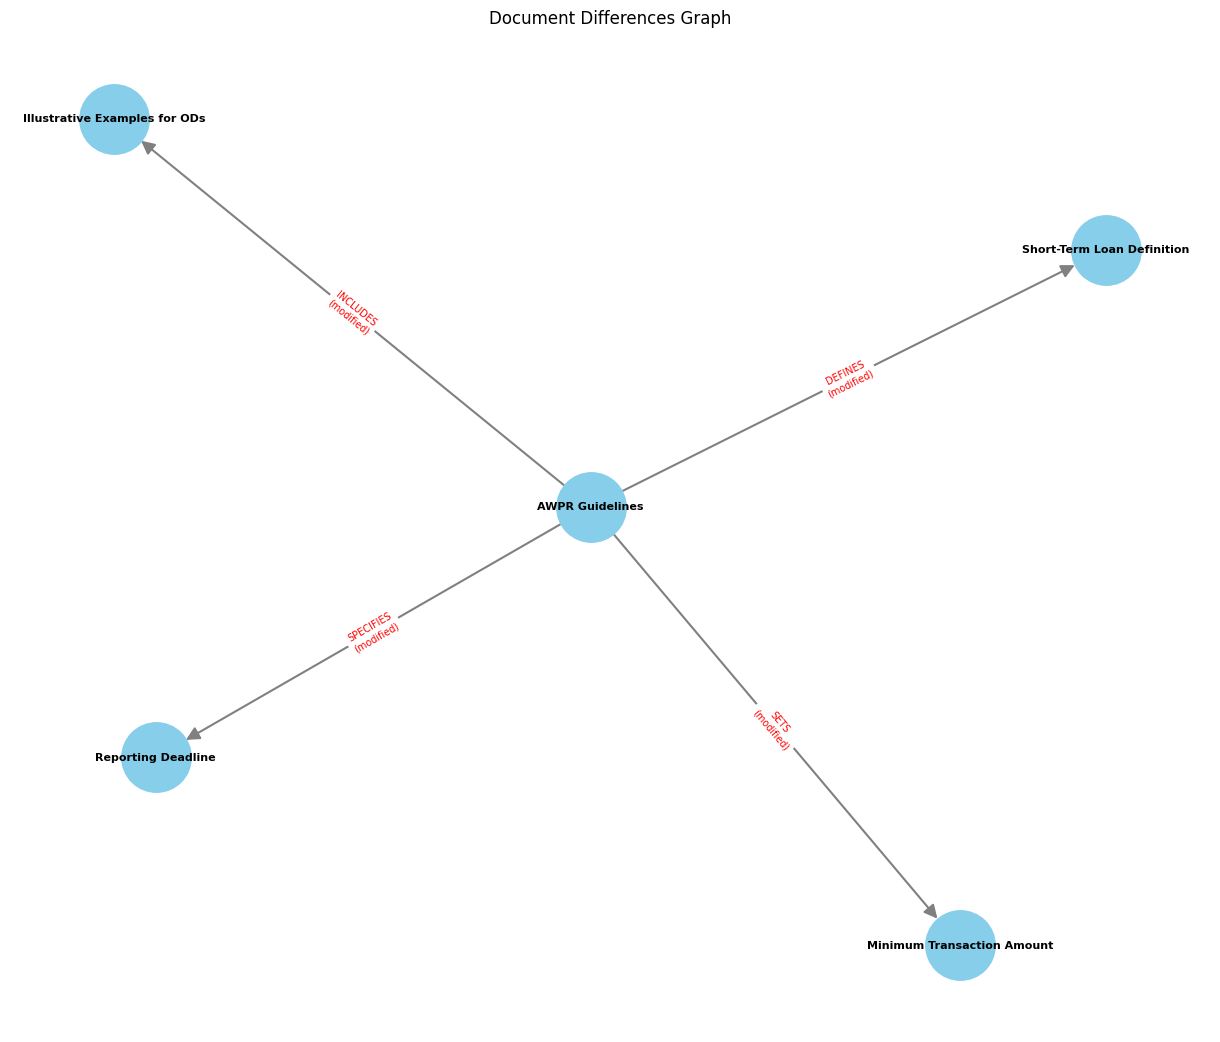

In [21]:
import networkx as nx
import json
import matplotlib.pyplot as plt # Optional: for basic plotting

def create_graph_from_json_diff(json_data):
    """
    Creates a NetworkX graph from a JSON structure describing differences
    between two versions of document entities and their relationships.

    Args:
        json_data (list): A list of dictionaries, where each dictionary
                          represents a changed relationship and the involved nodes.
                          The structure is expected to be as provided in the example.

    Returns:
        nx.DiGraph: A NetworkX directed graph representing the differences.
    """
    graph = nx.DiGraph()

    for item in json_data:
        source_node_data = item.get("source_node", {})
        target_node_data = item.get("target_node", {})
        relationship_data = item.get("relationship", {})
        change_description = item.get("change_description", "")

        # Add source node if it doesn't exist, or update its attributes
        if source_node_data.get("id"):
            if not graph.has_node(source_node_data["id"]):
                graph.add_node(
                    source_node_data["id"],
                    label=source_node_data.get("label", source_node_data["id"]),
                    type=source_node_data.get("type", "Unknown"),
                    description_v1=source_node_data.get("description_v1", "N/A"),
                    description_v2=source_node_data.get("description_v2", "N/A")
                )
            else: # Update descriptions if node already exists (can happen if a node is part of multiple changes)
                graph.nodes[source_node_data["id"]]['description_v1'] = source_node_data.get("description_v1", graph.nodes[source_node_data["id"]].get('description_v1', "N/A"))
                graph.nodes[source_node_data["id"]]['description_v2'] = source_node_data.get("description_v2", graph.nodes[source_node_data["id"]].get('description_v2', "N/A"))


        # Add target node if it doesn't exist, or update its attributes
        if target_node_data.get("id"):
            if not graph.has_node(target_node_data["id"]):
                graph.add_node(
                    target_node_data["id"],
                    label=target_node_data.get("label", target_node_data["id"]),
                    type=target_node_data.get("type", "Unknown"),
                    description_v1=target_node_data.get("description_v1", "N/A"),
                    description_v2=target_node_data.get("description_v2", "N/A")
                )
            else: # Update descriptions
                graph.nodes[target_node_data["id"]]['description_v1'] = target_node_data.get("description_v1", graph.nodes[target_node_data["id"]].get('description_v1', "N/A"))
                graph.nodes[target_node_data["id"]]['description_v2'] = target_node_data.get("description_v2", graph.nodes[target_node_data["id"]].get('description_v2', "N/A"))

        # Add the edge representing the relationship and its change
        if source_node_data.get("id") and target_node_data.get("id"):
            graph.add_edge(
                source_node_data["id"],
                target_node_data["id"],
                relationship_type=relationship_data.get("type", "RELATED_TO"),
                label_v1=relationship_data.get("label_v1", "N/A"),
                label_v2=relationship_data.get("label_v2", "N/A"),
                details_v1=relationship_data.get("details_v1", "N/A"),
                details_v2=relationship_data.get("details_v2", "N/A"),
                change_status=relationship_data.get("change_status", "unknown"),
                change_description=change_description
            )
    return graph

# --- Your JSON data ---
# Note: The provided JSON in the prompt was missing the initial '[' and final ']'
# and had a comma before the last '}'. I've corrected it here.
json_input_string = """
[
    {
        "source_node": {
            "id": "AWPR_Guidelines_v2",
            "label": "AWPR Guidelines",
            "type": "Document",
            "description_v1": "Guidelines for reporting the Average Weighted Prime Lending Rate (AWPR)",
            "description_v2": "Revised Guidelines for reporting the Average Weighted Prime Lending Rate (AWPR)"
        },
        "target_node": {
            "id": "Reporting_Deadline_v2",
            "label": "Reporting Deadline",
            "type": "Process",
            "description_v1": "12:00 noon each Friday",
            "description_v2": "2:00 PM each Friday"
        },
        "relationship": {
            "type": "SPECIFIES",
            "label_v1": "Specifies",
            "label_v2": "Specifies",
            "details_v1": "The reporting deadline for AWPR submissions.",
            "details_v2": "The reporting deadline for AWPR submissions.",
            "change_status": "modified"
        },
        "change_description": "The reporting deadline for AWPR submissions has been changed from 12:00 noon to 2:00 PM each Friday."
    },
    {
        "source_node": {
            "id": "AWPR_Guidelines_v2",
            "label": "AWPR Guidelines",
            "type": "Document",
            "description_v1": "Guidelines for reporting the Average Weighted Prime Lending Rate (AWPR)",
            "description_v2": "Revised Guidelines for reporting the Average Weighted Prime Lending Rate (AWPR)"
        },
        "target_node": {
            "id": "Short_Term_Loan_Definition_v2",
            "label": "Short-Term Loan Definition",
            "type": "Concept",
            "description_v1": "3 months or less",
            "description_v2": "6 months or less"
        },
        "relationship": {
            "type": "DEFINES",
            "label_v1": "Defines",
            "label_v2": "Defines",
            "details_v1": "The time period considered for short-term loans in AWPR calculations.",
            "details_v2": "The time period considered for short-term loans in AWPR calculations.",
            "change_status": "modified"
        },
        "change_description": "The definition of short-term loans for AWPR reporting has been extended from 3 months or less to 6 months or less."
    },
    {
        "source_node": {
            "id": "AWPR_Guidelines_v2",
            "label": "AWPR Guidelines",
            "type": "Document",
            "description_v1": "Guidelines for reporting the Average Weighted Prime Lending Rate (AWPR)",
            "description_v2": "Revised Guidelines for reporting the Average Weighted Prime Lending Rate (AWPR)"
        },
        "target_node": {
            "id": "Minimum_Transaction_Amount_v2",
            "label": "Minimum Transaction Amount",
            "type": "Threshold",
            "description_v1": "Rs. 10 million",
            "description_v2": "Rs. 15 million"
        },
        "relationship": {
            "type": "SETS",
            "label_v1": "Sets",
            "label_v2": "Sets",
            "details_v1": "The minimum transaction amount to be reported for AWPR.",
            "details_v2": "The minimum transaction amount to be reported for AWPR.",
            "change_status": "modified"
        },
        "change_description": "The minimum transaction amount to be reported for AWPR has been increased from Rs. 10 million to Rs. 15 million."
    },
    {
        "source_node": {
            "id": "AWPR_Guidelines_v2",
            "label": "AWPR Guidelines",
            "type": "Document",
            "description_v1": "Guidelines for reporting the Average Weighted Prime Lending Rate (AWPR)",
            "description_v2": "Revised Guidelines for reporting the Average Weighted Prime Lending Rate (AWPR)"
        },
        "target_node": {
            "id": "Illustrative_Examples_OD_v2",
            "label": "Illustrative Examples for ODs",
            "type": "Appendix",
            "description_v1": "Illustrative examples for overdrafts and similar credit lines when there's a change in interest rate.",
            "description_v2": "Illustrative examples for overdrafts and similar credit lines when there's a change in interest rate and when there is no change."
        },
        "relationship": {
            "type": "INCLUDES",
            "label_v1": "Includes",
            "label_v2": "Includes",
            "details_v1": "Appendix II with examples for rate change scenarios.",
            "details_v2": "Appendix II with examples for rate change and no rate change scenarios.",
            "change_status": "modified"
        },
        "change_description": "Appendix II has been modified to include illustrative examples for both interest rate change and no interest rate change scenarios for overdrafts and similar credit lines."
    }
]
"""

if __name__ == '__main__':
    # Load the JSON data
    try:
        data = json.loads(json_input_string)
    except json.JSONDecodeError as e:
        print(f"Error decoding JSON: {e}")
        data = []

    if data:
        diff_graph = create_graph_from_json_diff(data)

        print("Graph created successfully!")
        print(f"Number of nodes: {diff_graph.number_of_nodes()}")
        print(f"Number of edges: {diff_graph.number_of_edges()}")

        print("\nNodes (with attributes):")
        for node, attrs in diff_graph.nodes(data=True):
            print(f"  Node ID: {node}, Attributes: {attrs}")

        print("\nEdges (with attributes):")
        for u, v, attrs in diff_graph.edges(data=True):
            print(f"  Edge from {u} to {v}, Attributes: {attrs}")

        # Optional: Basic plotting of the graph (requires matplotlib)
        # For more advanced visualization, consider tools like Gephi, Cytoscape,
        # or Plotly/Dash for interactive web-based graphs.
        try:
            pos = nx.spring_layout(diff_graph, k=0.5, iterations=50) # Position nodes using a spring layout
            plt.figure(figsize=(12, 10))
            nx.draw(
                diff_graph,
                pos,
                with_labels=True,
                labels=nx.get_node_attributes(diff_graph, 'label'), # Use 'label' for node text
                node_size=2500,
                node_color="skyblue",
                font_size=8,
                font_weight="bold",
                edge_color="gray",
                width=1.5,
                arrowsize=20
            )
            # Add edge labels (e.g., change_status or relationship_type)
            edge_labels = {}
            for u, v, attrs in diff_graph.edges(data=True):
                 edge_labels[(u,v)] = f"{attrs.get('relationship_type')}\n({attrs.get('change_status')})"

            nx.draw_networkx_edge_labels(diff_graph, pos, edge_labels=edge_labels, font_size=7, font_color='red')

            plt.title("Document Differences Graph")
            plt.show()
        except ImportError:
            print("\nMatplotlib not found. Skipping basic graph plot.")
            print("To visualize, install matplotlib: pip install matplotlib")
        except Exception as e:
            print(f"\nError during plotting: {e}")

    else:
        print("No data to create graph.")
